In [346]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
from sklearn.linear_model import LinearRegression
import numpy as np


# loading up the CSV files into dataframes
leases_df = pd.read_csv("Leases.csv")
price_availability_df = pd.read_csv("Price and Availability Data.csv")
occupancy_df = pd.read_csv("Major Market Occupancy Data.csv")
unemployment_df = pd.read_csv("Unemployment.csv")

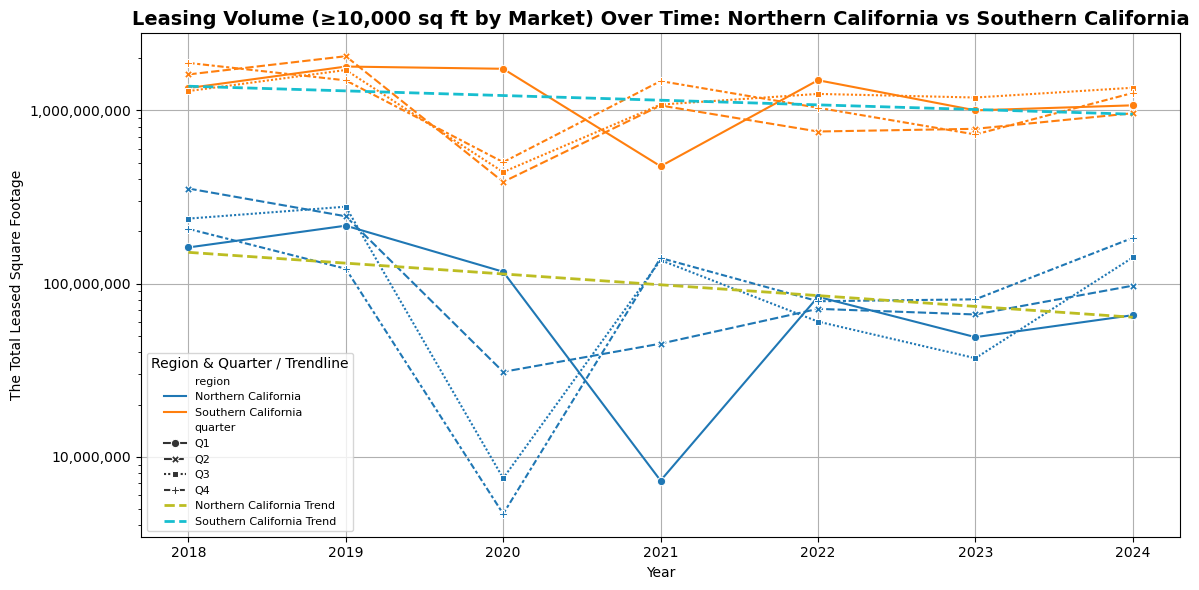

In [361]:
# Cleaning up the column names for easier access
leases_df.columns = leases_df.columns.str.lower()

norcal_markets = ['San Francisco', 'San Jose', 'South Bay']
socal_markets = ['Los Angeles', 'San Diego', 'Orange County (CA)']

# Converting the lease column to numeric
leases_df['leasing'] = pd.to_numeric(leases_df['leasing'], errors='coerce')
leases_df = leases_df.dropna(subset=['leasing'])

# Filtering for leases ≥ 10,000 sq ft
large_leases = leases_df[leases_df['leasing'] >= 10000]

# Create a region column based on MARKET instead of city
large_leases['region'] = large_leases['market'].apply(
    lambda x: 'Northern California' if any(m in x for m in norcal_markets)
    else 'Southern California' if any(m in x for m in socal_markets)
    else 'Other'
)

# Filter only Northern and Southern California (excluding Other regions)
target_leases = large_leases[large_leases['region'].isin(['Northern California', 'Southern California'])]

# Grouping by year, quarter, and region
leasing_trends = target_leases.groupby(['year', 'quarter', 'region'])['leasing'].sum().reset_index()

# ==== Trendline calculation: average by region and year ====
region_yearly = leasing_trends.groupby(['year', 'region'])['leasing'].mean().reset_index()

# Plotting the line chart
plt.figure(figsize=(12, 6))
sns.lineplot(data=leasing_trends, x='year', y='leasing', hue='region', style='quarter', markers=True)

# Add trendlines per region
for region in region_yearly['region'].unique():
    sub = region_yearly[region_yearly['region'] == region]
    
    # Fit regression line on log-transformed leasing data
    X = sub['year'].values.reshape(-1, 1)
    y_log = np.log(sub['leasing'])
    
    model = LinearRegression().fit(X, y_log)
    y_pred_log = model.predict(X)
    y_pred = np.exp(y_pred_log)  # Convert back to original scale
    
    # Plot trendline
    plt.plot(sub['year'], y_pred, linestyle='--', linewidth=2,
             label=f'{region} Trend')

# Final plot styling
plt.title('Leasing Volume (≥10,000 sq ft by Market) Over Time: Northern California vs Southern California',
          fontsize=14, weight='bold')
plt.ylabel('The Total Leased Square Footage')
plt.xlabel('Year')
plt.xticks(sorted(leasing_trends['year'].unique()))
plt.grid(True)

# Apply log scale and custom tick formatting
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Custom legend
plt.legend(title='Region & Quarter / Trendline', title_fontsize='10', fontsize='8')
plt.tight_layout()
plt.show()

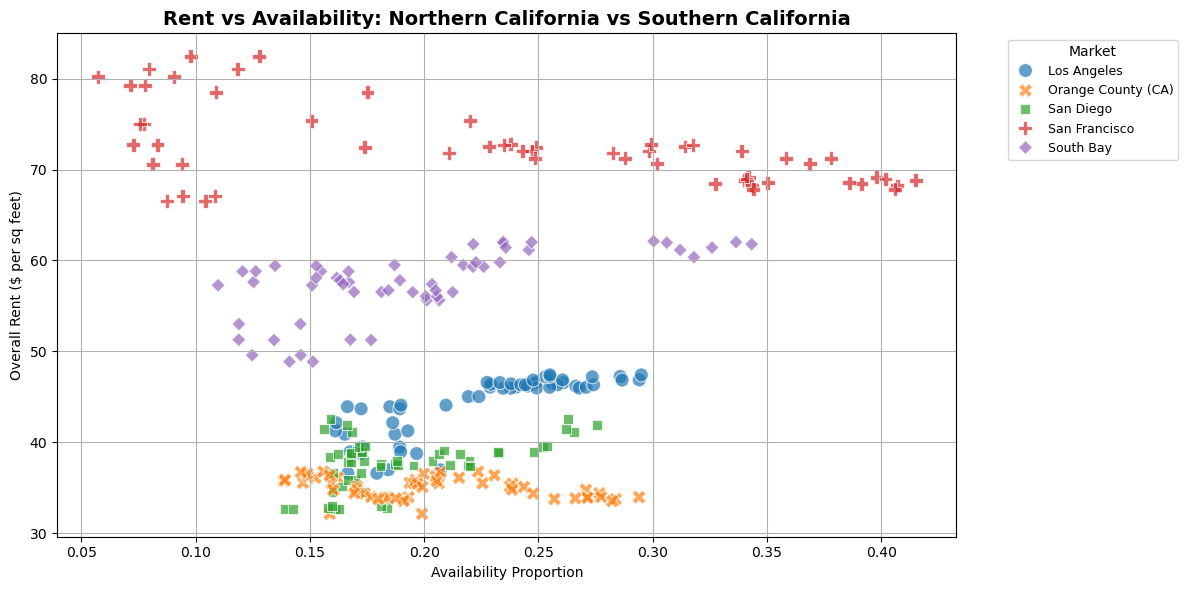

In [356]:
# cleaning up the column names
price_availability_df.columns = price_availability_df.columns.str.lower()

# focusing on only what is/are the relevant columns and regions
relevant_cols = ['year', 'quarter', 'market', 'overall_rent', 'availability_proportion']
region_prices = price_availability_df[relevant_cols].copy()

# Updated NorCal/SoCal based on actual 'market' values in the dataset
norcal = ['San Francisco', 'South Bay']
socal = ['Los Angeles', 'San Diego', 'Orange County (CA)']

# Filter only those markets
valid_markets = norcal + socal
region_prices = region_prices[region_prices['market'].isin(valid_markets)]

# drop the rows with missing values in key columns
region_prices = region_prices.dropna(subset=['overall_rent', 'availability_proportion'])

# taking plot's rent vs availability for all regions
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data = region_prices,
    x = 'availability_proportion',
    y = 'overall_rent',
    hue = 'market',
    style = 'market',
    s = 100,
    alpha = 0.7
)

# building the plot
plt.title('Rent vs Availability: Northern California vs Southern California', fontsize = 14, weight = 'bold')
plt.xlabel('Availability Proportion')
plt.ylabel('Overall Rent ($ per sq feet)')
plt.legend(title='Market', title_fontsize='10', fontsize='9', bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [321]:
# Standardizing columns to lowercase
leases_df.columns = leases_df.columns.str.lower()
price_availability_df.columns = price_availability_df.columns.str.lower()
occupancy_df.columns = occupancy_df.columns.str.lower()
unemployment_df.columns = unemployment_df.columns.str.lower()

# Creating 'year_quarter' for merging across datasets
for df in [leases_df, price_availability_df, occupancy_df, unemployment_df]:
    df['year_quarter'] = df['year'].astype(str) + "_" + df['quarter']

# Assigning region labels
norcal = ['San Francisco', 'San Jose']
socal = ['Los Angeles', 'San Diego', 'Orange County']

leases_df['region'] = leases_df['city'].apply(
    lambda x: 'NorCal' if x in norcal else 'SoCal' if x in socal else 'Other')

price_availability_df['region'] = price_availability_df['market'].apply(
    lambda x: 'NorCal' if x in norcal else 'SoCal' if x in socal else 'Other')

occupancy_df['region'] = occupancy_df['market'].apply(
    lambda x: 'NorCal' if 'San Francisco' in x else 'SoCal' if 'Los Angeles' in x else 'Other')

unemployment_df['region'] = unemployment_df['state'].apply(
    lambda x: 'NorCal' if x == 'CA' else 'SoCal' if x == 'CA' else 'Other')  # Optional: refine later

# Aggregating leasing data (10,000+ sq ft)
leases_filtered = leases_df[leases_df['leasing'] >= 10000][['year_quarter', 'region', 'leasing']]
leases_grouped = leases_filtered.groupby(['year_quarter', 'region'])['leasing'].sum().reset_index()

# Aggregating other datasets by region and year_quarter
price_grouped = price_availability_df[['year_quarter', 'region', 'overall_rent', 'availability_proportion']] \
    .groupby(['year_quarter', 'region']).mean().reset_index()

occupancy_grouped = occupancy_df[['year_quarter', 'region', 'occupancy_proportion']] \
    .groupby(['year_quarter', 'region']).mean().reset_index()

unemployment_grouped = unemployment_df[['year_quarter', 'region', 'unemployment_rate']] \
    .groupby(['year_quarter', 'region']).mean().reset_index()

# Merging all grouped datasets
merged_df = leases_grouped \
    .merge(price_grouped, on=['year_quarter', 'region'], how='left') \
    .merge(occupancy_grouped, on=['year_quarter', 'region'], how='left') \
    .merge(unemployment_grouped, on=['year_quarter', 'region'], how='left')

# Filter to only NorCal and SoCal
merged_df = merged_df[merged_df['region'].isin(['NorCal', 'SoCal'])]


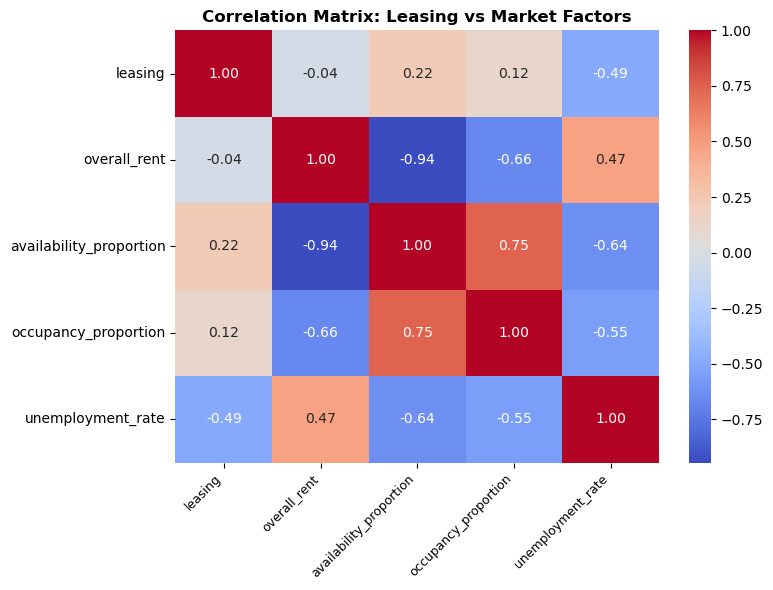

In [315]:
corr_data = merged_df[['leasing', 'overall_rent', 'availability_proportion', 'occupancy_proportion', 'unemployment_rate']].dropna()
corr_matrix = corr_data.corr()

# plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# clean up x-axis tick labels
plt.xticks(rotation = 45, ha = 'right', fontsize = 9)
plt.yticks(rotation = 0, fontsize = 10)

# title
plt.title("Correlation Matrix: Leasing vs Market Factors", weight = 'bold')
plt.tight_layout()
plt.show()


# The Limitations and Next Steps

While this analysis captures the key trends in leasing activity, pricing, and availability across major regions, there are a few limitations we can consider.
 
- **Lack of firm-level or sector-specific data**: We were unable to segment the leasing activity by the industry (legal vs technology), which could reveal more targeted microtrends 